# Proyecto 2
# Procesamiento de Lenguaje Natural basados en arquitecturas neuronales secuenciales.

## Librerias

In [1]:
import os
import re
import pandas as pd
import spacy
import random

## Preparación del Corpus

In [2]:
# Descargar el modelo de spaCy para español si no está ya descargado
# python -m spacy download es_core_news_sm

# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Rutas
RAW_PATH = "Data/raw_corpus.txt"          # entrada
OUT_DIR = "Data/processed"                # carpeta de salida

os.makedirs(OUT_DIR, exist_ok=True)

# Cargar el texto bruto
with open(RAW_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Longitud del texto bruto:", len(raw_text))
print(raw_text[:500])  # muestra un fragmento

Longitud del texto bruto: 11327
Érase un pobre campesino que estaba una noche junto al hogar atizando el fuego, mientras su mujer hilaba, sentada a su lado.
Dijo el hombre: – ¡Qué triste es no tener hijos! ¡Qué silencio en esta casa, mientras en las otras todo es ruido y alegría! – Sí -respondió la mujer, suspirando-. Aunque fuese uno solo, y aunque fuese pequeño como el pulgar, me daría por satisfecha. Lo querríamos más que nuestra vida.
Sucedió que la mujer se sintió descompuesta, y al cabo de siete meses trajo al mundo un n


### Limpieza básica

In [3]:
def clean_text(text: str) -> str:
    # Normalizar saltos de línea
    text = re.sub(r"[ \t]+\n", "\n", text)

    # Normalizar comillas curvas
    text = text.replace("“", "\"").replace("”", "\"").replace("’", "'").replace("‘", "'")

    # Eliminar guiones largos y variantes
    text = text.replace("—", " ").replace("–", " ").replace("-", " ")

    # Conservar solo:
    # letras, números, espacios, saltos de línea,
    # y puntuación común: . , ! ? ¿ ¡ : ;
    text = re.sub(
        r"[^a-zA-Z0-9áéíóúÁÉÍÓÚñÑüÜ \n\.\,\!\?\¿\¡\:\;]", 
        " ", 
        text
    )

    # Compactar espacios múltiples
    text = re.sub(r"[ \t]+", " ", text)

    # Normalizar saltos múltiples
    text = re.sub(r"\n{3,}", "\n\n", text)

    # Strip final
    text = text.strip()

    return text

clean_corpus = clean_text(raw_text)
print("Longitud del texto limpio:", len(clean_corpus))
print(clean_corpus[:500])

Longitud del texto limpio: 11189
Érase un pobre campesino que estaba una noche junto al hogar atizando el fuego, mientras su mujer hilaba, sentada a su lado.
Dijo el hombre: ¡Qué triste es no tener hijos! ¡Qué silencio en esta casa, mientras en las otras todo es ruido y alegría! Sí respondió la mujer, suspirando . Aunque fuese uno solo, y aunque fuese pequeño como el pulgar, me daría por satisfecha. Lo querríamos más que nuestra vida.
Sucedió que la mujer se sintió descompuesta, y al cabo de siete meses trajo al mundo un niño q


In [4]:
# Guardar el texto limpio
clean_corpus_path = os.path.join(OUT_DIR, "clean_corpus.txt").replace("\\", "/")
with open(clean_corpus_path, "w", encoding="utf-8") as f:
    f.write(clean_corpus)

print(f"Texto limpio guardado en: {clean_corpus_path}")

Texto limpio guardado en: Data/processed/clean_corpus.txt


### Tokenizacion y Segmentacion en oraciones

In [5]:
import string

# Todos los signos de puntuación estándar + los españoles
ALL_PUNCT = set(string.punctuation) | set("¡!¿?;:,.-—–()[]{}<>«»\"'…")

def remove_punct_from_sentence(text):
    return "".join(ch for ch in text if ch not in ALL_PUNCT)

# Procesar todo el corpus con spaCy
doc = nlp(clean_corpus)

sentences = []
tokens_per_sentence = []

for sent in doc.sents:
    sent_text = sent.text.strip()
    if not sent_text:
        continue
    
    # Lista de tokens de la oración, sin espacios
    toks = [tok.text for tok in sent if not tok.is_space]
    
    # Filtramos oraciones muy cortas si quieres (opcional)
    if len(toks) == 0:
        continue
    
    # Eliminar puntuación SOLO DESPUÉS DE segmentar la oración
    clean_sentence = remove_punct_from_sentence(sent_text)

    # volver a tokenizar la oración limpia por espacios
    clean_tokens = clean_sentence.split()

    # evitar oraciones vacías
    if len(clean_tokens) == 0:
        continue

    sentences.append(clean_sentence)
    tokens_per_sentence.append(clean_tokens)

print("Número de oraciones detectadas:", len(sentences))
for i in range(min(5, len(sentences))):
    print(f"\nOración {i}: {sentences[i]}")
    print("Tokens:", tokens_per_sentence[i])

Número de oraciones detectadas: 121

Oración 0: Érase un pobre campesino que estaba una noche junto al hogar atizando el fuego mientras su mujer hilaba sentada a su lado
Tokens: ['Érase', 'un', 'pobre', 'campesino', 'que', 'estaba', 'una', 'noche', 'junto', 'al', 'hogar', 'atizando', 'el', 'fuego', 'mientras', 'su', 'mujer', 'hilaba', 'sentada', 'a', 'su', 'lado']

Oración 1: Dijo el hombre Qué triste es no tener hijos Qué silencio en esta casa mientras en las otras todo es ruido y alegría
Tokens: ['Dijo', 'el', 'hombre', 'Qué', 'triste', 'es', 'no', 'tener', 'hijos', 'Qué', 'silencio', 'en', 'esta', 'casa', 'mientras', 'en', 'las', 'otras', 'todo', 'es', 'ruido', 'y', 'alegría']

Oración 2: Sí respondió la mujer suspirando 
Tokens: ['Sí', 'respondió', 'la', 'mujer', 'suspirando']

Oración 3: Aunque fuese uno solo y aunque fuese pequeño como el pulgar me daría por satisfecha
Tokens: ['Aunque', 'fuese', 'uno', 'solo', 'y', 'aunque', 'fuese', 'pequeño', 'como', 'el', 'pulgar', 'me', 'dar

In [6]:
tokenized_sentences_str = [" ".join(toks) for toks in tokens_per_sentence]

data_df = pd.DataFrame({
    "id": list(range(len(sentences))),
    "sentence": sentences,
    "tokens": tokenized_sentences_str
})

all_sentences_path = os.path.join(OUT_DIR, "sentences_tokenized_spacy.csv").replace("\\", "/")
data_df.to_csv(all_sentences_path, index=False, encoding="utf-8")
print(f"Datos tokenizados guardados en: {all_sentences_path}")


Datos tokenizados guardados en: Data/processed/sentences_tokenized_spacy.csv


### División de entrenamiento, validación y prueba

In [7]:
indices = list(range(len(data_df)))
random.shuffle(indices)

n_total = len(indices)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

train_df = data_df.iloc[train_idx].reset_index(drop=True)
val_df = data_df.iloc[val_idx].reset_index(drop=True)
test_df = data_df.iloc[test_idx].reset_index(drop=True)

print("Tamaños:")
print("train:", len(train_df))
print("val:  ", len(val_df))
print("test: ", len(test_df))

train_path = os.path.join(OUT_DIR, "train_sentences_spacy.csv").replace("\\", "/")
val_path = os.path.join(OUT_DIR, "val_sentences_spacy.csv").replace("\\", "/")
test_path = os.path.join(OUT_DIR, "test_sentences_spacy.csv").replace("\\", "/")

train_df.to_csv(train_path, index=False, encoding="utf-8")
val_df.to_csv(val_path, index=False, encoding="utf-8")
test_df.to_csv(test_path, index=False, encoding="utf-8")

print("\nConjuntos guardados en:")
print("- Train:", train_path)
print("- Validation:", val_path)
print("- Test:", test_path)

Tamaños:
train: 96
val:   12
test:  13

Conjuntos guardados en:
- Train: Data/processed/train_sentences_spacy.csv
- Validation: Data/processed/val_sentences_spacy.csv
- Test: Data/processed/test_sentences_spacy.csv


## Modelos Secuenciales

### Red Neuronal Recurrente (RNN)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#### Construcción del vocabulario y secuencias numéricas

In [9]:
train_path = os.path.join(OUT_DIR, "train_sentences_spacy.csv").replace("\\", "/")
val_path = os.path.join(OUT_DIR, "val_sentences_spacy.csv").replace("\\", "/")

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)

print(train_df.head())

    id                                           sentence  \
0   29  Pero Pulgarcito que había oído la proposición ...   
1   39  Pegó él unos brincos entre unos terruños y de ...   
2    9  Un día en que el leñador se disponía a ir al b...   
3  114  Ay exclamó el padre  cuánta angustia nos has h...   
4   66  La criada que seguía al acecho oyó con toda cl...   

                                              tokens  
0  Pero Pulgarcito que había oído la proposición ...  
1  Pegó él unos brincos entre unos terruños y de ...  
2  Un día en que el leñador se disponía a ir al b...  
3  Ay exclamó el padre cuánta angustia nos has he...  
4  La criada que seguía al acecho oyó con toda cl...  


In [10]:
def build_vocab(token_series, min_freq=1):
    """
    Construye el vocabulario a partir de una serie de pandas que contiene oraciones tokenizadas como strings.
    Args:
        token_series (pd.Series): Serie de pandas con oraciones tokenizadas como strings.
        min_freq (int): Frecuencia mínima para incluir un token en el vocabulario.  
    Returns:
        stoi (dict): Mapeo de token a índice.
        itos (list): Lista de tokens en orden de índice.
    """
    counter = Counter()
    for row in token_series:
        tokens = str(row).split()
        counter.update(tokens)
    
    # Tokens especiales
    stoi = {"<PAD>": 0, "<UNK>": 1}
    itos = ["<PAD>", "<UNK>"]
    
    for tok, freq in counter.items():
        if freq >= min_freq:
            stoi[tok] = len(itos)
            itos.append(tok)
    
    return stoi, itos

stoi, itos = build_vocab(train_df["tokens"], min_freq=1)
vocab_size = len(itos)
print("Tamaño del vocabulario:", vocab_size)
print("Ejemplo de tokens:", itos[:30])

Tamaño del vocabulario: 702
Ejemplo de tokens: ['<PAD>', '<UNK>', 'Pero', 'Pulgarcito', 'que', 'había', 'oído', 'la', 'proposición', 'agarrándose', 'a', 'un', 'pliegue', 'de', 'los', 'calzones', 'su', 'padre', 'se', 'encaramó', 'hasta', 'hombro', 'y', 'le', 'murmuró', 'al', 'Padre', 'dejame', 'vaya', 'ya']


#### Construcción de secuencias para predicción de siguiente palabra

In [11]:
def tokens_to_ids(tokens_str, stoi):
    return [stoi.get(tok, stoi["<UNK>"]) for tok in str(tokens_str).split()]

# Convertir todo el train a una sola lista de índices
train_ids = []
for row in train_df["tokens"]:
    train_ids.extend(tokens_to_ids(row, stoi))

val_ids = []
for row in val_df["tokens"]:
    val_ids.extend(tokens_to_ids(row, stoi))

print("Longitud total de train_ids:", len(train_ids))
print("Ejemplo de ids:", train_ids[:20])

Longitud total de train_ids: 1579
Ejemplo de ids: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 13, 16, 17, 18, 19, 20]


In [12]:
SEQ_LEN = 10

def build_sequences(id_list, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(id_list) - seq_len):
        X.append(id_list[i:i+seq_len])
        y.append(id_list[i+seq_len])
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

X_train, y_train = build_sequences(train_ids, SEQ_LEN)
X_val, y_val = build_sequences(val_ids, SEQ_LEN)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: torch.Size([1569, 10])
y_train shape: torch.Size([1569])


#### Dataset y DataLoader

In [13]:
class NextWordDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NextWordDataset(X_train, y_train)
val_dataset = NextWordDataset(X_val, y_val)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


#### Definición del modelo RNN

In [14]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x, hidden=None):
        # x: (batch, seq_len)
        emb = self.embedding(x)               # (batch, seq_len, embed_dim)
        out, hidden = self.rnn(emb, hidden)   # out: (batch, seq_len, hidden_dim)
        # Tomamos la última salida de la secuencia
        last_out = out[:, -1, :]              # (batch, hidden_dim)
        logits = self.fc(last_out)            # (batch, vocab_size)
        return logits, hidden

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNLanguageModel(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, num_layers=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

RNNLanguageModel(
  (embedding): Embedding(702, 128)
  (rnn): RNN(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=702, bias=True)
)


#### Entrenamiento de la RNN

In [15]:
EPOCHS = 10
train_losses = []
val_losses = []
train_accs = []
val_accs = []


def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)

            # loss acumulada
            batch_size = y_batch.size(0)
            total_loss += loss.item() * batch_size
            total_examples += batch_size

            # accuracy
            preds = torch.argmax(logits, dim=-1)   # (batch,)
            total_correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total_examples
    accuracy = total_correct / total_examples
    return avg_loss, accuracy


In [16]:
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits, _ = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size
        total_examples += batch_size

        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == y_batch).sum().item()

    train_loss = total_loss / total_examples
    train_acc = total_correct / total_examples

    val_loss, val_acc = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"[RNN] Epoch {epoch}/{EPOCHS} | "
          f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")


[RNN] Epoch 1/10 | Train loss: 6.5696 | Train acc: 0.0045 | Val loss: 6.5065 | Val acc: 0.0203
[RNN] Epoch 2/10 | Train loss: 6.0768 | Train acc: 0.0784 | Val loss: 6.4556 | Val acc: 0.0761
[RNN] Epoch 3/10 | Train loss: 5.5342 | Train acc: 0.0790 | Val loss: 6.3206 | Val acc: 0.0761
[RNN] Epoch 4/10 | Train loss: 5.0938 | Train acc: 0.1319 | Val loss: 6.2741 | Val acc: 0.0711
[RNN] Epoch 5/10 | Train loss: 4.7165 | Train acc: 0.1523 | Val loss: 6.2907 | Val acc: 0.0761
[RNN] Epoch 6/10 | Train loss: 4.3512 | Train acc: 0.1874 | Val loss: 6.1784 | Val acc: 0.0964
[RNN] Epoch 7/10 | Train loss: 4.0118 | Train acc: 0.2428 | Val loss: 6.2285 | Val acc: 0.0863
[RNN] Epoch 8/10 | Train loss: 3.6666 | Train acc: 0.2792 | Val loss: 6.2320 | Val acc: 0.1015
[RNN] Epoch 9/10 | Train loss: 3.3361 | Train acc: 0.3505 | Val loss: 6.3152 | Val acc: 0.0964
[RNN] Epoch 10/10 | Train loss: 3.0116 | Train acc: 0.4060 | Val loss: 6.3024 | Val acc: 0.0964


#### Prueba cualitativa: predicción de la siguiente palabra

In [17]:
def ids_to_tokens(ids, itos):
    return [itos[i] for i in ids]

def predict_next_word(model, prompt_tokens, stoi, itos, top_k=5):
    model.eval()
    # Convertir tokens a ids
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in prompt_tokens]
    # Asegurar longitud SEQ_LEN (truncar o padear al inicio con <PAD>)
    if len(ids) < SEQ_LEN:
        ids = [stoi["<PAD>"]] * (SEQ_LEN - len(ids)) + ids
    else:
        ids = ids[-SEQ_LEN:]
    
    x = torch.tensor([ids], dtype=torch.long).to(device)
    with torch.no_grad():
        logits, _ = model(x)
        probs = torch.softmax(logits[0], dim=-1)
        top_probs, top_ids = torch.topk(probs, k=top_k)
    
    candidates = [(itos[top_ids[i].item()], top_probs[i].item()) for i in range(top_k)]
    return candidates

prompt = ["Pulgarcito", "dijo", "al", "padre", "que"]
candidates = predict_next_word(model, prompt, stoi, itos, top_k=5)

print("Prompt:", " ".join(prompt))
print("Siguientes palabras más probables:")
for w, p in candidates:
    print(f"{w}\t{p:.4f}")


Prompt: Pulgarcito dijo al padre que
Siguientes palabras más probables:
amaneciese	0.0304
lleva	0.0260
estaba	0.0257
había	0.0210
dentro	0.0203


#### Gráficos

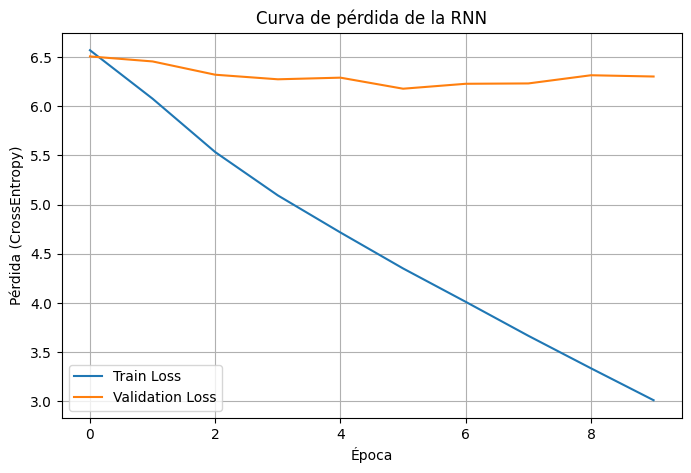

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title("Curva de pérdida de la RNN")
plt.legend()
plt.grid(True)
plt.show()

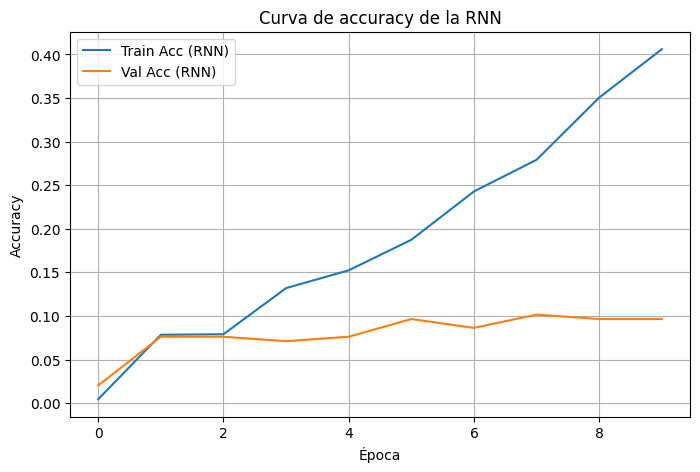

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_accs, label="Train Acc (RNN)")
plt.plot(val_accs, label="Val Acc (RNN)")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Curva de accuracy de la RNN")
plt.legend()
plt.grid(True)
plt.show()

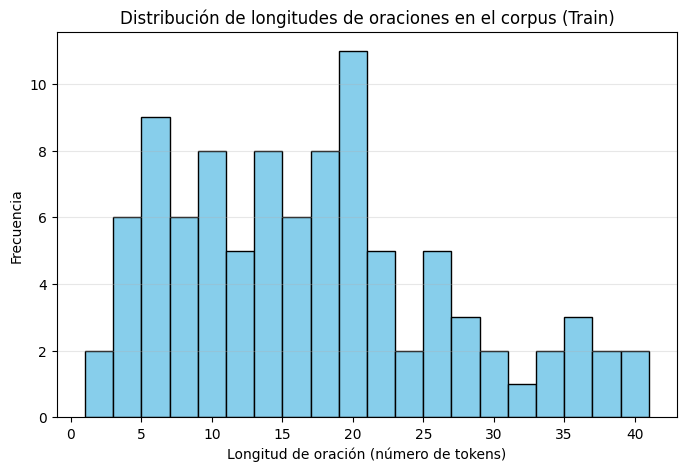

In [20]:
sentence_lengths = [len(toks.split()) for toks in train_df["tokens"]]

plt.figure(figsize=(8, 5))
plt.hist(sentence_lengths, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Longitud de oración (número de tokens)")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes de oraciones en el corpus (Train)")
plt.grid(axis="y", alpha=0.3)
plt.show()

### Modelo LSTM (Long Short-Term Memory)

In [21]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        emb = self.embedding(x)           # (batch, seq_len, embed_dim)
        out, hidden = self.lstm(emb)      # (batch, seq_len, hidden_dim)
        last_out = out[:, -1, :]          # tomamos solo la última salida
        logits = self.fc(last_out)        # (batch, vocab_size)
        return logits, hidden

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMLanguageModel(
    vocab_size=vocab_size,
    embed_dim=64,
    hidden_dim=64,
    num_layers=1,
    dropout=0.0
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

print(lstm_model)

LSTMLanguageModel(
  (embedding): Embedding(702, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=702, bias=True)
)


#### Entrenamiento de la LSTM

In [23]:
EPOCHS_LSTM = 10
train_losses_lstm = []
val_losses_lstm = []
train_accs_lstm = []
val_accs_lstm = []


for epoch in range(1, EPOCHS_LSTM + 1):
    lstm_model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits, _ = lstm_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = y_batch.size(0)
        total_loss += loss.item() * batch_size
        total_examples += batch_size

        preds = torch.argmax(logits, dim=-1)
        total_correct += (preds == y_batch).sum().item()

    train_loss = total_loss / total_examples
    train_acc = total_correct / total_examples

    val_loss, val_acc = evaluate(lstm_model, val_loader, device)

    train_losses_lstm.append(train_loss)
    val_losses_lstm.append(val_loss)
    train_accs_lstm.append(train_acc)
    val_accs_lstm.append(val_acc)

    print(f"[LSTM] Epoch {epoch}/{EPOCHS_LSTM} | "
          f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f} | Val acc: {val_acc:.4f}")

[LSTM] Epoch 1/10 | Train loss: 6.5420 | Train acc: 0.0032 | Val loss: 6.5451 | Val acc: 0.0152
[LSTM] Epoch 2/10 | Train loss: 6.4170 | Train acc: 0.0300 | Val loss: 6.4721 | Val acc: 0.0203
[LSTM] Epoch 3/10 | Train loss: 6.0258 | Train acc: 0.0382 | Val loss: 6.4841 | Val acc: 0.0254
[LSTM] Epoch 4/10 | Train loss: 5.7274 | Train acc: 0.0478 | Val loss: 6.4638 | Val acc: 0.0355
[LSTM] Epoch 5/10 | Train loss: 5.5929 | Train acc: 0.0631 | Val loss: 6.5558 | Val acc: 0.0406
[LSTM] Epoch 6/10 | Train loss: 5.4740 | Train acc: 0.0733 | Val loss: 6.5349 | Val acc: 0.0305
[LSTM] Epoch 7/10 | Train loss: 5.3487 | Train acc: 0.0822 | Val loss: 6.6065 | Val acc: 0.0305
[LSTM] Epoch 8/10 | Train loss: 5.2137 | Train acc: 0.0803 | Val loss: 6.6539 | Val acc: 0.0355
[LSTM] Epoch 9/10 | Train loss: 5.0774 | Train acc: 0.0994 | Val loss: 6.6211 | Val acc: 0.0305
[LSTM] Epoch 10/10 | Train loss: 4.9440 | Train acc: 0.1052 | Val loss: 6.6947 | Val acc: 0.0305


#### Gráfica: Pérdida (Train vs Validation) – LSTM

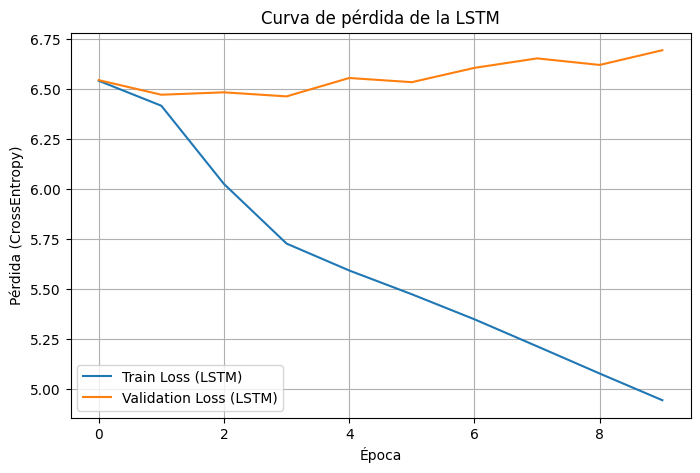

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses_lstm, label="Train Loss (LSTM)")
plt.plot(val_losses_lstm, label="Validation Loss (LSTM)")
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title("Curva de pérdida de la LSTM")
plt.legend()
plt.grid(True)
plt.show()

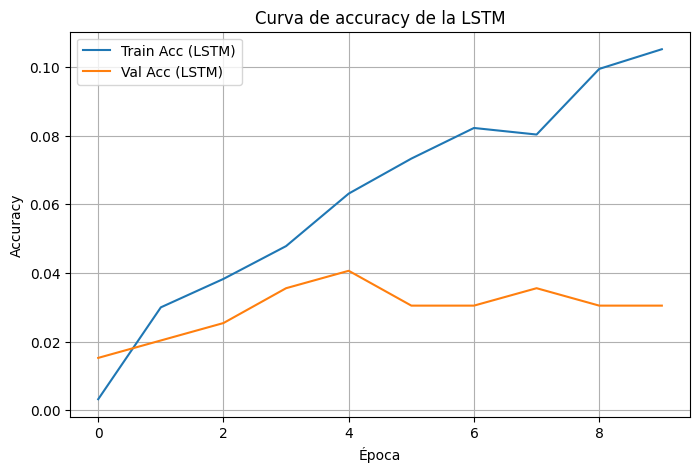

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(train_accs_lstm, label="Train Acc (LSTM)")
plt.plot(val_accs_lstm, label="Val Acc (LSTM)")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Curva de accuracy de la LSTM")
plt.legend()
plt.grid(True)
plt.show()

### Modelo Sequence-to-Sequence (Seq2Seq)

#### Construcción de pares (entrada -> salida)

In [26]:
IN_LEN = 10
OUT_LEN = 10

def build_seq2seq_pairs(id_list, in_len=IN_LEN, out_len=OUT_LEN):
    X_src, X_tgt = [], []
    max_i = len(id_list) - in_len - out_len
    for i in range(max_i):
        src = id_list[i : i + in_len]                 # entrada
        tgt = id_list[i + in_len : i + in_len + out_len]  # salida (lo que sigue)
        X_src.append(src)
        X_tgt.append(tgt)
    return torch.tensor(X_src, dtype=torch.long), torch.tensor(X_tgt, dtype=torch.long)

X_train_src, X_train_tgt = build_seq2seq_pairs(train_ids, IN_LEN, OUT_LEN)
X_val_src, X_val_tgt     = build_seq2seq_pairs(val_ids,   IN_LEN, OUT_LEN)

print("X_train_src shape:", X_train_src.shape)  # (N, IN_LEN)
print("X_train_tgt shape:", X_train_tgt.shape)  # (N, OUT_LEN)
print("X_val_src shape:  ", X_val_src.shape)
print("X_val_tgt shape:  ", X_val_tgt.shape)


X_train_src shape: torch.Size([1559, 10])
X_train_tgt shape: torch.Size([1559, 10])
X_val_src shape:   torch.Size([187, 10])
X_val_tgt shape:   torch.Size([187, 10])


#### Dataset y DataLoader para Seq2Seq

In [27]:
class Seq2SeqDataset(Dataset):
    def __init__(self, src, tgt):
        self.src = src
        self.tgt = tgt
    
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, idx):
        return self.src[idx], self.tgt[idx]

seq2seq_train_dataset = Seq2SeqDataset(X_train_src, X_train_tgt)
seq2seq_val_dataset   = Seq2SeqDataset(X_val_src,   X_val_tgt)

BATCH_SIZE_SEQ2SEQ = 64

seq2seq_train_loader = DataLoader(seq2seq_train_dataset, batch_size=BATCH_SIZE_SEQ2SEQ, shuffle=True)
seq2seq_val_loader   = DataLoader(seq2seq_val_dataset,   batch_size=BATCH_SIZE_SEQ2SEQ)


#### Definición del modelo Encoder–Decoder (Seq2Seq con LSTM)

In [28]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
    
    def forward(self, src):
        """
        src: (batch, src_len)
        """
        embedded = self.embedding(src)                 # (batch, src_len, embed_dim)
        outputs, (hidden, cell) = self.lstm(embedded)  # outputs: (batch, src_len, hidden_dim)
        # Nos quedamos con los estados ocultos finales
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, input_token, hidden, cell):
        """
        input_token: (batch,)  índices de la palabra actual de entrada al decoder
        hidden, cell: estados del LSTM
        """
        input_token = input_token.unsqueeze(1)         # (batch, 1)
        embedded = self.embedding(input_token)         # (batch, 1, embed_dim)
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # outputs: (batch, 1, hidden_dim)
        logits = self.fc_out(outputs.squeeze(1))       # (batch, vocab_size)
        return logits, hidden, cell

In [29]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        """
        src: (batch, src_len)
        tgt: (batch, tgt_len)  -> usaremos tgt como "gold" para teacher forcing
        """
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        vocab_size = self.decoder.fc_out.out_features
        
        # Tensor para guardar todos los logits
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        
        # Encoder
        hidden, cell = self.encoder(src)
        
        # Primer input al decoder: usaremos el último token de la secuencia de entrada
        input_token = src[:, -1]  # (batch,)
        
        for t in range(tgt_len):
            logits, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t, :] = logits
            
            # Decidimos si usamos teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = logits.argmax(1)  # (batch,)
            
            # Siguiente input: palabra gold o predicha
            input_token = tgt[:, t] if teacher_force else top1
        
        return outputs


#### Entrenamiento del modelo Seq2Seq

In [30]:
encoder = Encoder(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, num_layers=2, dropout=0.1).to(device)
decoder = Decoder(vocab_size=vocab_size, embed_dim=128, hidden_dim=128, num_layers=2, dropout=0.1).to(device)
seq2seq_model = Seq2Seq(encoder, decoder, device).to(device)

criterion_seq2seq = nn.CrossEntropyLoss()
optimizer_seq2seq = torch.optim.Adam(seq2seq_model.parameters(), lr=1e-3)

EPOCHS_SEQ2SEQ = 10
train_losses_seq2seq = []
val_losses_seq2seq = []

In [31]:
def evaluate_seq2seq(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    
    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            # Sin teacher forcing en validación
            outputs = model(src_batch, tgt_batch, teacher_forcing_ratio=0.0)
            # outputs: (batch, tgt_len, vocab_size)
            # tgt_batch: (batch, tgt_len)
            
            # Aplanamos para CrossEntropy
            logits_flat = outputs.view(-1, vocab_size)      # (batch*tgt_len, vocab_size)
            targets_flat = tgt_batch.view(-1)               # (batch*tgt_len,)
            
            loss = criterion_seq2seq(logits_flat, targets_flat)
            
            batch_tokens = targets_flat.size(0)
            total_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens
    
    avg_loss = total_loss / total_tokens
    return avg_loss

In [32]:
for epoch in range(1, EPOCHS_SEQ2SEQ + 1):
    seq2seq_model.train()
    total_loss = 0.0
    total_tokens = 0
    
    for src_batch, tgt_batch in seq2seq_train_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        
        optimizer_seq2seq.zero_grad()
        outputs = seq2seq_model(src_batch, tgt_batch, teacher_forcing_ratio=0.5)
        
        # outputs: (batch, tgt_len, vocab_size)
        logits_flat = outputs.view(-1, vocab_size)
        targets_flat = tgt_batch.view(-1)
        
        loss = criterion_seq2seq(logits_flat, targets_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), max_norm=5.0)
        optimizer_seq2seq.step()
        
        batch_tokens = targets_flat.size(0)
        total_loss += loss.item() * batch_tokens
        total_tokens += batch_tokens
    
    train_loss = total_loss / total_tokens
    val_loss = evaluate_seq2seq(seq2seq_model, seq2seq_val_loader, device)
    
    train_losses_seq2seq.append(train_loss)
    val_losses_seq2seq.append(val_loss)
    
    print(f"[Seq2Seq] Epoch {epoch}/{EPOCHS_SEQ2SEQ} | "
          f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")


[Seq2Seq] Epoch 1/10 | Train loss: 6.2406 | Val loss: 6.1803
[Seq2Seq] Epoch 2/10 | Train loss: 5.7861 | Val loss: 6.4290
[Seq2Seq] Epoch 3/10 | Train loss: 5.7599 | Val loss: 6.5823
[Seq2Seq] Epoch 4/10 | Train loss: 5.7413 | Val loss: 6.6117
[Seq2Seq] Epoch 5/10 | Train loss: 5.7056 | Val loss: 6.6427
[Seq2Seq] Epoch 6/10 | Train loss: 5.6325 | Val loss: 6.7049
[Seq2Seq] Epoch 7/10 | Train loss: 5.4914 | Val loss: 6.7437
[Seq2Seq] Epoch 8/10 | Train loss: 5.2761 | Val loss: 6.8418
[Seq2Seq] Epoch 9/10 | Train loss: 5.0211 | Val loss: 6.8756
[Seq2Seq] Epoch 10/10 | Train loss: 4.7314 | Val loss: 7.0130


#### Gráfica: Pérdida (Train vs Validation) – Seq2Seq

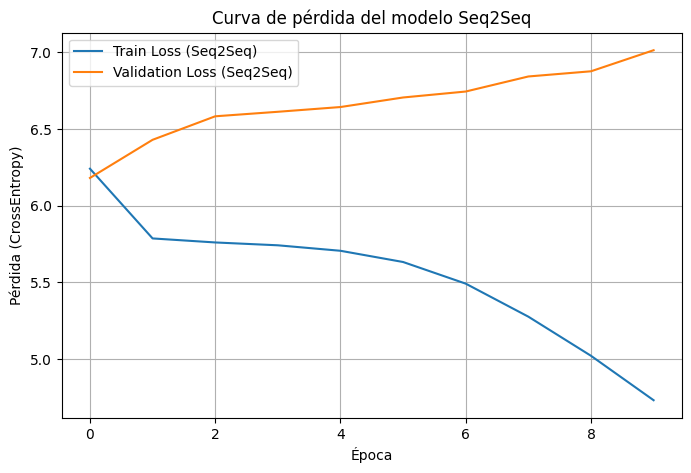

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses_seq2seq, label="Train Loss (Seq2Seq)")
plt.plot(val_losses_seq2seq, label="Validation Loss (Seq2Seq)")
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title("Curva de pérdida del modelo Seq2Seq")
plt.legend()
plt.grid(True)
plt.show()


#### Prueba cualitativa: generación con Seq2Seq

In [34]:
def generate_with_seq2seq(model, prompt_tokens, stoi, itos, in_len=IN_LEN, out_len=OUT_LEN):
    model.eval()
    # Convertir tokens a ids
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in prompt_tokens]
    
    # Asegurar longitud in_len (pad al inicio si es corto)
    if len(ids) < in_len:
        ids = [stoi["<PAD>"]] * (in_len - len(ids)) + ids
    else:
        ids = ids[-in_len:]
    
    src = torch.tensor([ids], dtype=torch.long).to(device)  # (1, in_len)
    
    # Para el target dummy solo usamos padding; el modelo se ejecuta sin teacher forcing
    tgt_dummy = torch.zeros((1, out_len), dtype=torch.long).to(device)
    
    with torch.no_grad():
        outputs = model(src, tgt_dummy, teacher_forcing_ratio=0.0)  # (1, out_len, vocab_size)
        preds = outputs.argmax(dim=-1).squeeze(0).tolist()          # (out_len,)
    
    generated_tokens = [itos[i] for i in preds]
    return generated_tokens

prompt = ["Pulgarcito", "dijo", "al", "padre", "que"]
generated = generate_with_seq2seq(seq2seq_model, prompt, stoi, itos, in_len=IN_LEN, out_len=OUT_LEN)

print("Prompt:", " ".join(prompt))
print("Generado:", " ".join(generated))

Prompt: Pulgarcito dijo al padre que
Generado: le le le le por el en el el en


### Mecanismo de Atención (Luong) sobre Seq2Seq

In [35]:
class EncoderAttn(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
    
    def forward(self, src):
        """
        src: (batch, src_len)
        returns:
            encoder_outputs: (batch, src_len, hidden_dim)
            hidden, cell: (num_layers, batch, hidden_dim)
        """
        embedded = self.embedding(src)                  # (batch, src_len, embed_dim)
        encoder_outputs, (hidden, cell) = self.lstm(embedded)
        return encoder_outputs, hidden, cell


In [36]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        # Proyección del estado del decoder antes del producto escalar
        self.Wa = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, decoder_hidden, encoder_outputs):
        """
        decoder_hidden: (batch, hidden_dim) -> estado actual del decoder
        encoder_outputs: (batch, src_len, hidden_dim) -> todas las salidas del encoder
        
        returns:
            context: (batch, hidden_dim)
            attn_weights: (batch, src_len)  -> distribución de atención sobre la entrada
        """
        # (batch, hidden_dim) -> (batch, hidden_dim, 1)
        dec_proj = self.Wa(decoder_hidden).unsqueeze(2)
        
        # scores = encoder_outputs · dec_proj   -> (batch, src_len)
        # encoder_outputs: (batch, src_len, hidden_dim)
        scores = torch.bmm(encoder_outputs, dec_proj).squeeze(2)
        
        # pesos de atención normalizados
        attn_weights = self.softmax(scores)    # (batch, src_len)
        
        # contexto = suma ponderada de encoder_outputs
        # (batch, 1, src_len) x (batch, src_len, hidden_dim) -> (batch, 1, hidden_dim)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context, attn_weights


In [37]:
class DecoderWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        
        self.attention = LuongAttention(hidden_dim)
        # Combinaremos [decoder_hidden; context] -> 2 * hidden_dim
        self.fc_combined = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.tanh = nn.Tanh()
    
    def forward(self, input_token, hidden, cell, encoder_outputs):
        """
        input_token: (batch,)  token de entrada actual al decoder
        hidden, cell: estados del LSTM
        encoder_outputs: (batch, src_len, hidden_dim)
        
        returns:
            logits: (batch, vocab_size)
            hidden, cell: estados actualizados
            attn_weights: (batch, src_len)
        """
        # Embedding del token actual
        input_token = input_token.unsqueeze(1)          # (batch, 1)
        embedded = self.embedding(input_token)          # (batch, 1, embed_dim)
        
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # outputs: (batch, 1, hidden_dim)
        dec_hidden = outputs.squeeze(1)                 # (batch, hidden_dim)
        
        # Atención sobre las salidas del encoder
        context, attn_weights = self.attention(dec_hidden, encoder_outputs)
        
        # Concatenar hidden del decoder con el contexto de atención
        combined = torch.cat([dec_hidden, context], dim=1)    # (batch, 2*hidden_dim)
        combined = self.tanh(self.fc_combined(combined))      # (batch, hidden_dim)
        
        logits = self.fc_out(combined)                        # (batch, vocab_size)
        return logits, hidden, cell, attn_weights


#### Modelo Seq2Seq con Atención

In [38]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        """
        src: (batch, src_len)
        tgt: (batch, tgt_len)
        """
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        vocab_size = self.decoder.fc_out.out_features
        
        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(self.device)
        
        # Encoder
        encoder_outputs, hidden, cell = self.encoder(src)
        
        # Primer input al decoder: último token de la secuencia de entrada
        input_token = src[:, -1]  # (batch,)
        
        for t in range(tgt_len):
            logits, hidden, cell, attn_weights = self.decoder(
                input_token, hidden, cell, encoder_outputs
            )
            outputs[:, t, :] = logits
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = logits.argmax(1)  # (batch,)
            
            input_token = tgt[:, t] if teacher_force else top1
        
        return outputs


#### Entrenamiento del modelo Seq2Seq con Atención

In [39]:
encoder_attn = EncoderAttn(vocab_size=vocab_size, embed_dim=128, hidden_dim=128,
                           num_layers=2, dropout=0.1).to(device)
decoder_attn = DecoderWithAttention(vocab_size=vocab_size, embed_dim=128, hidden_dim=128,
                                    num_layers=2, dropout=0.1).to(device)

seq2seq_attn_model = Seq2SeqWithAttention(encoder_attn, decoder_attn, device).to(device)

criterion_attn = nn.CrossEntropyLoss()
optimizer_attn = torch.optim.Adam(seq2seq_attn_model.parameters(), lr=1e-3)

EPOCHS_SEQ2SEQ_ATTN = 10
train_losses_seq2seq_attn = []
val_losses_seq2seq_attn = []

def evaluate_seq2seq_attn(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    
    with torch.no_grad():
        for src_batch, tgt_batch in data_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            outputs = model(src_batch, tgt_batch, teacher_forcing_ratio=0.0)
            logits_flat = outputs.view(-1, vocab_size)
            targets_flat = tgt_batch.view(-1)
            loss = criterion_attn(logits_flat, targets_flat)
            
            batch_tokens = targets_flat.size(0)
            total_loss += loss.item() * batch_tokens
            total_tokens += batch_tokens
    
    return total_loss / total_tokens

In [40]:
for epoch in range(1, EPOCHS_SEQ2SEQ_ATTN + 1):
    seq2seq_attn_model.train()
    total_loss = 0.0
    total_tokens = 0
    
    for src_batch, tgt_batch in seq2seq_train_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        
        optimizer_attn.zero_grad()
        outputs = seq2seq_attn_model(src_batch, tgt_batch, teacher_forcing_ratio=0.5)
        
        logits_flat = outputs.view(-1, vocab_size)
        targets_flat = tgt_batch.view(-1)
        
        loss = criterion_attn(logits_flat, targets_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seq2seq_attn_model.parameters(), max_norm=5.0)
        optimizer_attn.step()
        
        batch_tokens = targets_flat.size(0)
        total_loss += loss.item() * batch_tokens
        total_tokens += batch_tokens
    
    train_loss = total_loss / total_tokens
    val_loss = evaluate_seq2seq_attn(seq2seq_attn_model, seq2seq_val_loader, device)
    
    train_losses_seq2seq_attn.append(train_loss)
    val_losses_seq2seq_attn.append(val_loss)
    
    print(f"[Seq2Seq+Attn] Epoch {epoch}/{EPOCHS_SEQ2SEQ_ATTN} | "
          f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

[Seq2Seq+Attn] Epoch 1/10 | Train loss: 6.1788 | Val loss: 6.2060
[Seq2Seq+Attn] Epoch 2/10 | Train loss: 5.7894 | Val loss: 6.4784
[Seq2Seq+Attn] Epoch 3/10 | Train loss: 5.7708 | Val loss: 6.7311
[Seq2Seq+Attn] Epoch 4/10 | Train loss: 5.7572 | Val loss: 6.7426
[Seq2Seq+Attn] Epoch 5/10 | Train loss: 5.6887 | Val loss: 6.7437
[Seq2Seq+Attn] Epoch 6/10 | Train loss: 5.5108 | Val loss: 6.7937
[Seq2Seq+Attn] Epoch 7/10 | Train loss: 5.2431 | Val loss: 6.8640
[Seq2Seq+Attn] Epoch 8/10 | Train loss: 4.9356 | Val loss: 6.9580
[Seq2Seq+Attn] Epoch 9/10 | Train loss: 4.6103 | Val loss: 7.1058
[Seq2Seq+Attn] Epoch 10/10 | Train loss: 4.2907 | Val loss: 7.2787


#### Gráfica: Pérdida (Train vs Validation) – Seq2Seq con Atención

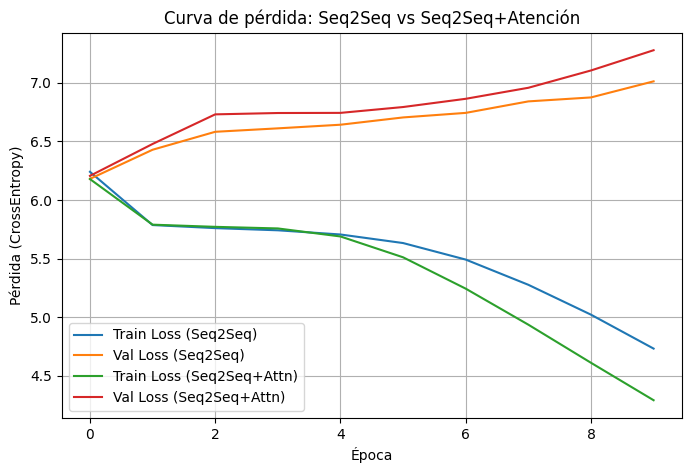

In [41]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses_seq2seq, label="Train Loss (Seq2Seq)")
plt.plot(val_losses_seq2seq, label="Val Loss (Seq2Seq)")
plt.plot(train_losses_seq2seq_attn, label="Train Loss (Seq2Seq+Attn)")
plt.plot(val_losses_seq2seq_attn, label="Val Loss (Seq2Seq+Attn)")
plt.xlabel("Época")
plt.ylabel("Pérdida (CrossEntropy)")
plt.title("Curva de pérdida: Seq2Seq vs Seq2Seq+Atención")
plt.legend()
plt.grid(True)
plt.show()


#### Métricas: Accuracy, BLEU y ROUGE-1 en validación

In [42]:
from collections import Counter

# Intentamos importar BLEU de nltk. Si no está, solo calculamos Accuracy y ROUGE-1.
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    have_nltk_bleu = True
    smoothie = SmoothingFunction().method4
except ImportError:
    have_nltk_bleu = False
    print("nltk no está instalado o no tiene BLEU. Se omitirá BLEU.")

def rouge1_f1(ref_tokens, pred_tokens):
    ref_counts = Counter(ref_tokens)
    pred_counts = Counter(pred_tokens)
    overlap = sum((ref_counts & pred_counts).values())
    
    if len(pred_tokens) == 0:
        precision = 0.0
    else:
        precision = overlap / len(pred_tokens)
    
    if len(ref_tokens) == 0:
        recall = 0.0
    else:
        recall = overlap / len(ref_tokens)
    
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    return precision, recall, f1

def evaluate_metrics_seq2seq(model, data_loader, stoi, itos, max_batches=None):
    model.eval()
    total_tokens = 0
    total_correct = 0
    
    bleu_scores = []
    rouge_f1_scores = []
    
    with torch.no_grad():
        for b_idx, (src_batch, tgt_batch) in enumerate(data_loader):
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)   # (batch, tgt_len)
            
            outputs = model(src_batch, tgt_batch, teacher_forcing_ratio=0.0)
            preds = outputs.argmax(dim=-1)     # (batch, tgt_len)
            
            # Accuracy de tokens
            matches = (preds == tgt_batch).sum().item()
            total_correct += matches
            total_tokens += tgt_batch.numel()
            
            # Métricas a nivel de secuencia
            batch_size, tgt_len = tgt_batch.shape
            for i in range(batch_size):
                ref_ids = tgt_batch[i].tolist()
                pred_ids = preds[i].tolist()
                
                ref_tokens = [itos[idx] for idx in ref_ids]
                pred_tokens = [itos[idx] for idx in pred_ids]
                
                # BLEU (si está disponible)
                if have_nltk_bleu:
                    bleu = sentence_bleu(
                        [ref_tokens],
                        pred_tokens,
                        smoothing_function=smoothie
                    )
                    bleu_scores.append(bleu)
                
                # ROUGE-1 F1
                _, _, f1 = rouge1_f1(ref_tokens, pred_tokens)
                rouge_f1_scores.append(f1)
            
            if max_batches is not None and (b_idx + 1) >= max_batches:
                break
    
    accuracy = total_correct / total_tokens if total_tokens > 0 else 0.0
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if (have_nltk_bleu and len(bleu_scores) > 0) else None
    avg_rouge1_f1 = sum(rouge_f1_scores) / len(rouge_f1_scores) if len(rouge_f1_scores) > 0 else 0.0
    
    return accuracy, avg_bleu, avg_rouge1_f1

# Evaluación en validación (puedes limitar max_batches para que no sea tan lento)
acc_seq2seq, bleu_seq2seq, rouge_seq2seq = evaluate_metrics_seq2seq(
    seq2seq_model, seq2seq_val_loader, stoi, itos, max_batches=50
)

acc_seq2seq_attn, bleu_seq2seq_attn, rouge_seq2seq_attn = evaluate_metrics_seq2seq(
    seq2seq_attn_model, seq2seq_val_loader, stoi, itos, max_batches=50
)

print("=== Métricas en validación ===")
print(f"Seq2Seq - Accuracy: {acc_seq2seq:.4f}, "
      f"BLEU: {bleu_seq2seq if bleu_seq2seq is not None else 'N/A'}, "
      f"ROUGE-1 F1: {rouge_seq2seq:.4f}")

print(f"Seq2Seq+Attn - Accuracy: {acc_seq2seq_attn:.4f}, "
      f"BLEU: {bleu_seq2seq_attn if bleu_seq2seq_attn is not None else 'N/A'}, "
      f"ROUGE-1 F1: {rouge_seq2seq_attn:.4f}")


=== Métricas en validación ===
Seq2Seq - Accuracy: 0.0364, BLEU: 0.015108726231834043, ROUGE-1 F1: 0.0904
Seq2Seq+Attn - Accuracy: 0.0235, BLEU: 0.010944729331864536, ROUGE-1 F1: 0.0492


#### Prueba cualitativa y visualización del mapa de atención

Prompt: Pulgarcito dijo al padre que
Generado (con atención): a el a a a a a a a a


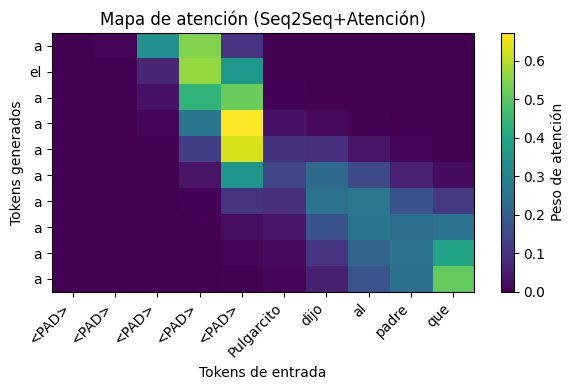

In [43]:
import numpy as np

def generate_with_attention(model, prompt_tokens, stoi, itos, in_len=IN_LEN, out_len=OUT_LEN):
    model.eval()
    
    # Convertimos tokens a ids y ajustamos longitud de entrada
    ids = [stoi.get(tok, stoi["<UNK>"]) for tok in prompt_tokens]
    if len(ids) < in_len:
        ids = [stoi["<PAD>"]] * (in_len - len(ids)) + ids
    else:
        ids = ids[-in_len:]
    
    src = torch.tensor([ids], dtype=torch.long).to(device)  # (1, in_len)
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src)  # encoder_outputs: (1, in_len, hidden_dim)
        
        input_token = src[:, -1]  # (1,)
        generated_ids = []
        attn_matrices = []
        
        for t in range(out_len):
            logits, hidden, cell, attn_weights = model.decoder(
                input_token, hidden, cell, encoder_outputs
            )
            probs = torch.softmax(logits, dim=-1)
            top1 = torch.argmax(probs, dim=-1)  # (1,)
            
            generated_ids.append(top1.item())
            attn_matrices.append(attn_weights[0].cpu().numpy())  # (src_len,)
            
            input_token = top1
        
    generated_tokens = [itos[idx] for idx in generated_ids]
    attn_matrix = np.stack(attn_matrices, axis=0)  # (out_len, src_len)
    
    return generated_tokens, attn_matrix, ids

def plot_attention(src_ids, generated_tokens, attn_matrix, itos):
    src_tokens = [itos[idx] for idx in src_ids]
    
    plt.figure(figsize=(max(6, len(src_tokens)*0.5), max(4, len(generated_tokens)*0.4)))
    plt.imshow(attn_matrix, aspect="auto", interpolation="nearest")
    plt.colorbar(label="Peso de atención")
    
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45, ha="right")
    plt.yticks(range(len(generated_tokens)), generated_tokens)
    
    plt.xlabel("Tokens de entrada")
    plt.ylabel("Tokens generados")
    plt.title("Mapa de atención (Seq2Seq+Atención)")
    plt.tight_layout()
    plt.show()

# Ejemplo de uso
prompt = ["Pulgarcito", "dijo", "al", "padre", "que"]
generated_tokens_attn, attn_matrix, src_ids = generate_with_attention(
    seq2seq_attn_model, prompt, stoi, itos, in_len=IN_LEN, out_len=OUT_LEN
)

print("Prompt:", " ".join(prompt))
print("Generado (con atención):", " ".join(generated_tokens_attn))

plot_attention(src_ids, generated_tokens_attn, attn_matrix, itos)
